## Prerequisite

In [ ]:
!uv pip install seaborn numpy matplotlib scikit-learn scipy
!uv pip install jax jaxlib
!uv pip install flax optax
!uv pip install jax-metal
!uv pip install tqdm
!uv pip install ipywidgets
!uv pip install blackjax

In [2]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"

In [3]:
from sklearn.datasets import make_swiss_roll
from typing import Sequence

import jax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax
import blackjax
from functools import partial
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('mystyle.mplstyle')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [6.0, 4.0]



## Loading Toy Dataset

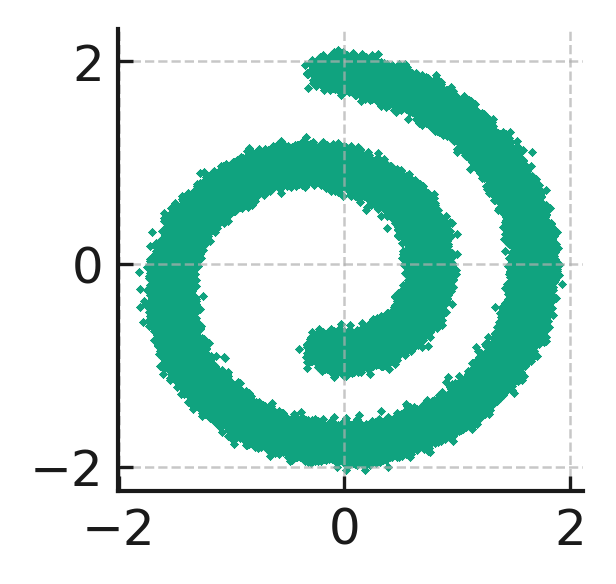

In [4]:
x, _ = make_swiss_roll(n_samples=100000, noise=0.5)
x = x[:, [0, 2]]

x = (x - x.mean()) / x.std()

plt.figure(figsize=(2, 2))
plt.scatter(x[:, 0], x[:, 1], s=1)

### MLP

In [5]:
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    x = jnp.square(x)
    return x

### Fitting the Energy Function on this toy distribution

In [6]:
@jax.jit
def energy(state, params, x):
    return state.apply_fn({'params': params}, x).squeeze()

@jax.jit
def grad_energy_wrt_x(state, params, x):
    return jax.vmap(jax.grad(energy, argnums=2), in_axes=(None, None, 0))(state, params, x)

@jax.jit
def sample_langevin_dynamics(key, state, params, x, num_steps=3, step_size=0.01):
    def step(i, x):
        noise = jax.random.normal(jax.random.fold_in(key, i), shape=x.shape)
        grad = grad_energy_wrt_x(state, params, x)
        x = x - (step_size / 2.) * grad + jnp.sqrt(step_size) * noise
        return x
    
    return jax.lax.fori_loop(0, num_steps, step, x)

@partial(jax.jit, static_argnums=(4, 5))
def sample_langevin_dynamics_with_trajectory(key, state, params, x, num_steps, step_size):
    def step(carry, _):
        i, x, subkey = carry
        noise = jax.random.normal(subkey, shape=x.shape)
        grad = grad_energy_wrt_x(state, params, x)
        x = x - (step_size / 2.) * grad + jnp.sqrt(step_size) * noise
        return (i + 1, x, jax.random.fold_in(subkey, i)), x
    
    _, trajectory = jax.lax.scan(step, (0, x, key), None, length=num_steps)
    return trajectory

### Train the model using Langevin MCMC and Contrastive Divergence

In [7]:
@jax.jit
def train_mcmc_with_langevin(state, batch, key):
    key, subkey = jax.random.split(key)
    # prior = jax.random.normal(subkey, (256, 2))
    model_samples = sample_langevin_dynamics(subkey, state, state.params, batch)
    model_samples = jax.lax.stop_gradient(model_samples)

    def loss_fn(params):
        concat_samples = jnp.concatenate([batch, model_samples], axis=0)
        energies = energy(state, params, concat_samples)
        data_energy, model_energy = jnp.split(energies, 2)

        regularisation = 0.1 * (data_energy ** 2 + model_energy ** 2).mean()

        return data_energy.mean() - model_energy.mean() + regularisation

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

In [8]:
x = make_swiss_roll(n_samples=100000, noise=0.5)[0]
x = x[:, [0, 2]]

x = (x - x.mean()) / x.std()

In [9]:
model = MLP(features=[2, 128, 128, 1])
variables = model.init(jax.random.PRNGKey(0), x[0])

tx = optax.chain(
    optax.clip_by_global_norm(2.0),
    optax.adamw(learning_rate=1e-3)
)
key = jax.random.PRNGKey(0)
state = train_state.TrainState.create(apply_fn=model.apply, params=variables["params"], tx=tx)

In [10]:
# Training loop
num_epochs = 400
batch_size = 128

for epoch in range(num_epochs):
    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, x.shape[0])
    permed_x = x[perm]
    
    for i in range(0, x.shape[0], batch_size):
        batch = jnp.array(permed_x[i:i + batch_size])
        key, subkey = jax.random.split(key)
        state, loss = train_mcmc_with_langevin(state, batch, subkey)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss}")

print("Training complete.")

Epoch 5, Loss: -0.027844073250889778
Epoch 10, Loss: -0.24987268447875977
Epoch 15, Loss: -0.2089756429195404
Epoch 20, Loss: -0.08906944841146469
Epoch 25, Loss: -0.4373477101325989
Epoch 30, Loss: -0.14334799349308014
Epoch 35, Loss: -0.17223097383975983
Epoch 40, Loss: -0.09568309783935547
Epoch 45, Loss: -0.3717656135559082
Epoch 50, Loss: -0.19611263275146484
Epoch 55, Loss: -0.35321417450904846
Epoch 60, Loss: 0.16293545067310333


KeyboardInterrupt: 

### Sampled Datapoints Visualisation

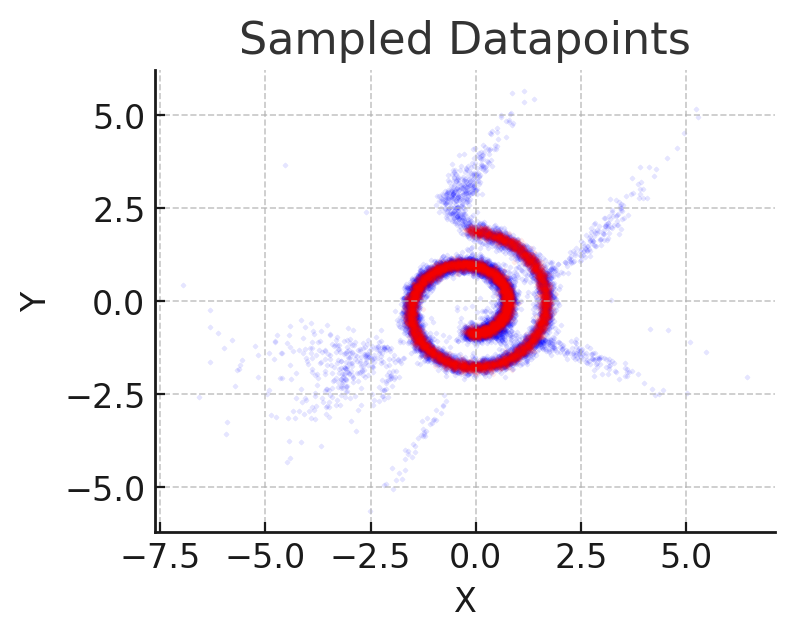

In [11]:
prior = jax.random.normal(key, (10000, 2))
model_samples = sample_langevin_dynamics(key, state, state.params, prior, num_steps=200, step_size=0.01)

plt.figure(figsize=(4, 3), dpi=200)
plt.scatter(model_samples[:, 0], model_samples[:, 1], s=1, color='blue', alpha=0.1)
plt.scatter(x[:10000, 0], x[:10000, 1], s=1, color='red', alpha=0.08)
plt.title('Sampled Datapoints')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

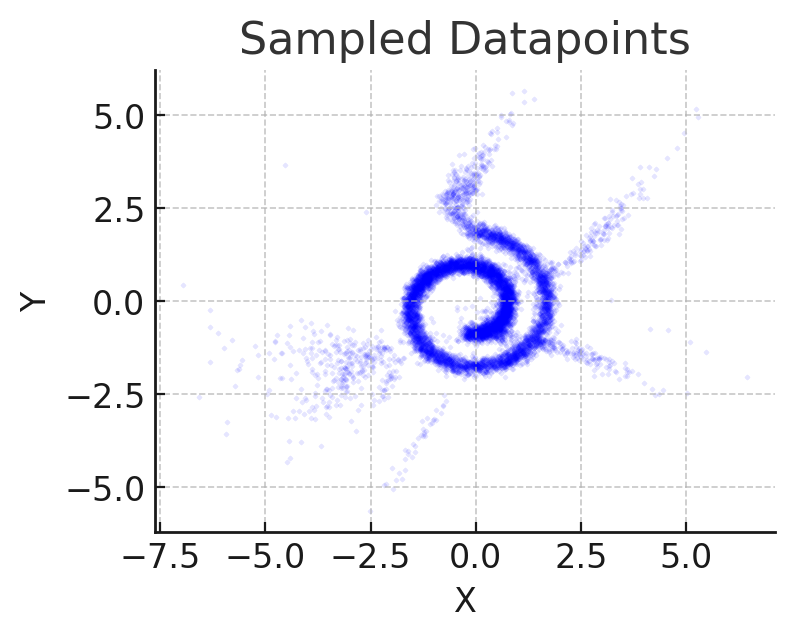

In [12]:
plt.figure(figsize=(4, 3), dpi=200)
plt.scatter(model_samples[:, 0], model_samples[:, 1], s=1, color='blue', alpha=0.1)
# plt.scatter(x[:10000, 0], x[:10000, 1], s=1, color='red', alpha=0.08)
plt.title('Sampled Datapoints')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Trajectories Visualisation

In [13]:
def visualize_langevin_trajectories(state, params, trajectories):
    # Plotting
    fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
    
    colors = plt.cm.rainbow(np.linspace(0, 1, trajectories.shape[1]))
    
    for i in range(trajectories.shape[1]):
        trajectory = trajectories[:, i, :]
        ax.plot(trajectory[:, 0], trajectory[:, 1], c=colors[i], alpha=0.5, linewidth=1)
        ax.scatter(trajectory[0, 0], trajectory[0, 1], c=[colors[i]], s=50, marker='o', label=f'Start {i+1}')
        ax.scatter(trajectory[-1, 0], trajectory[-1, 1], c=[colors[i]], s=50, marker='s', label=f'End {i+1}')
    
    ax.set_title('Langevin Dynamics Trajectories')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.get_legend().remove()
    plt.tight_layout()
    plt.show()

    # Plot energy landscape
    x_range = np.linspace(-3, 3, 100)
    y_range = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x_range, y_range)
    XY = jnp.array(np.column_stack([X.ravel(), Y.ravel()]))
    
    # print(XY.shape)
    energies = state.apply_fn({'params': params}, XY).reshape(X.shape)
    # energies = np.array(jax.vmap(lambda x: energy(params, x))(XY)).reshape(X.shape)
    
    fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
    contour = ax.contourf(X, Y, energies, levels=50, cmap='viridis')
    fig.colorbar(contour, ax=ax, label='Energy')
    
    for i in range(trajectories.shape[1]):
        trajectory = trajectories[:, i, :]
        ax.plot(trajectory[:, 0], trajectory[:, 1], c=colors[i], alpha=0.8, linewidth=2)
        ax.scatter(trajectory[0, 0], trajectory[0, 1], c=[colors[i]], s=50, marker='o', label=f'Start {i+1}')
        ax.scatter(trajectory[-1, 0], trajectory[-1, 1], c=[colors[i]], s=50, marker='s', label=f'End {i+1}')
    
    ax.set_title('Langevin Dynamics Trajectories on Energy Landscape')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.get_legend().remove()
    plt.tight_layout()
    plt.show()

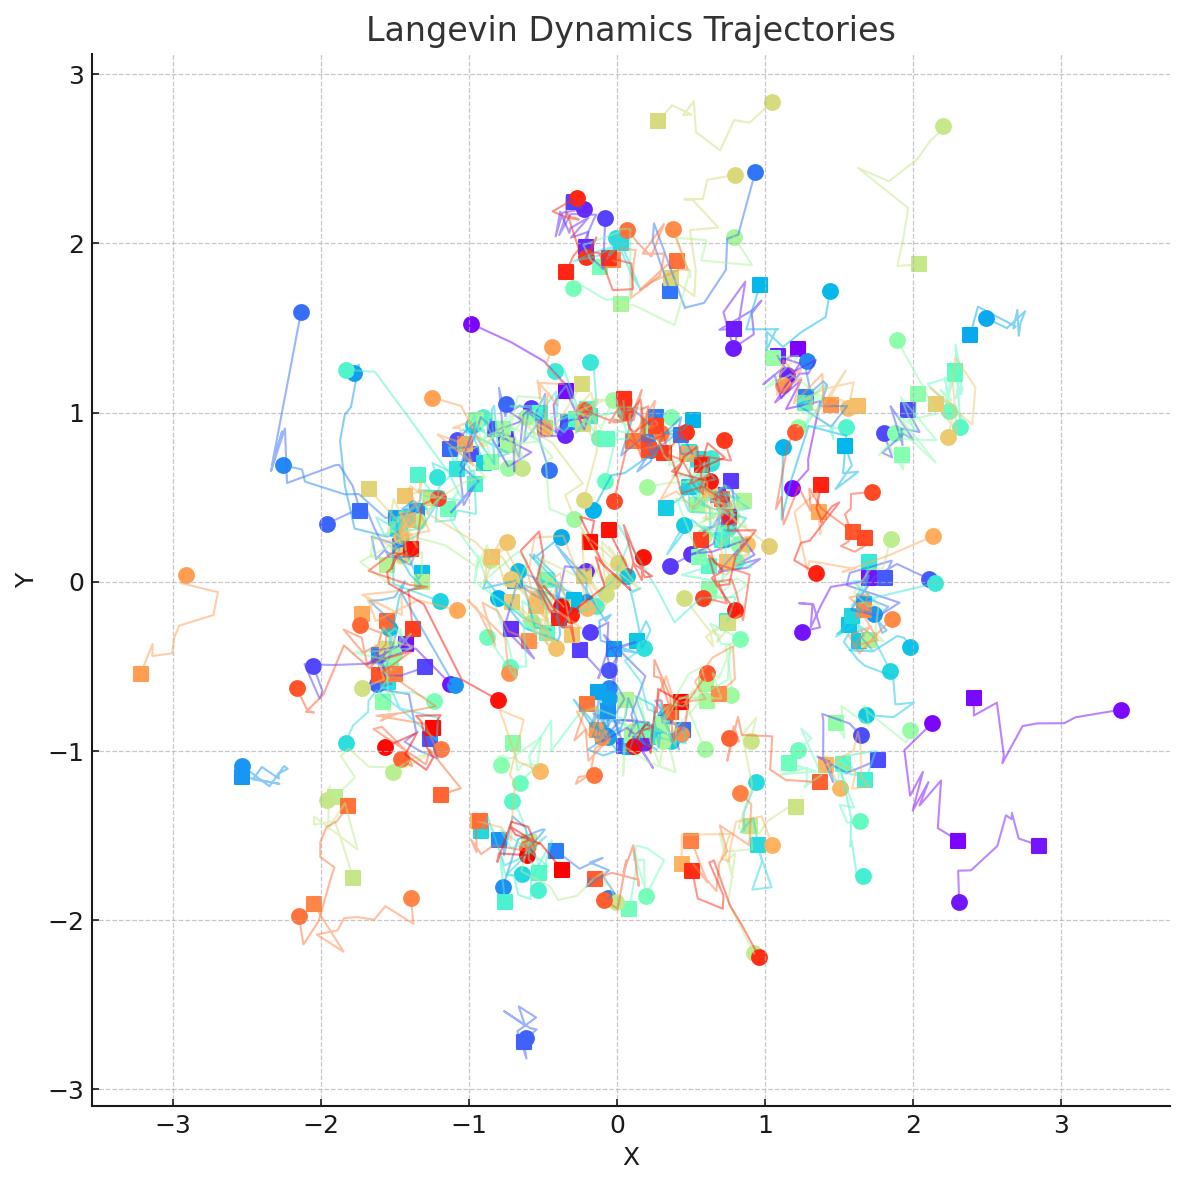

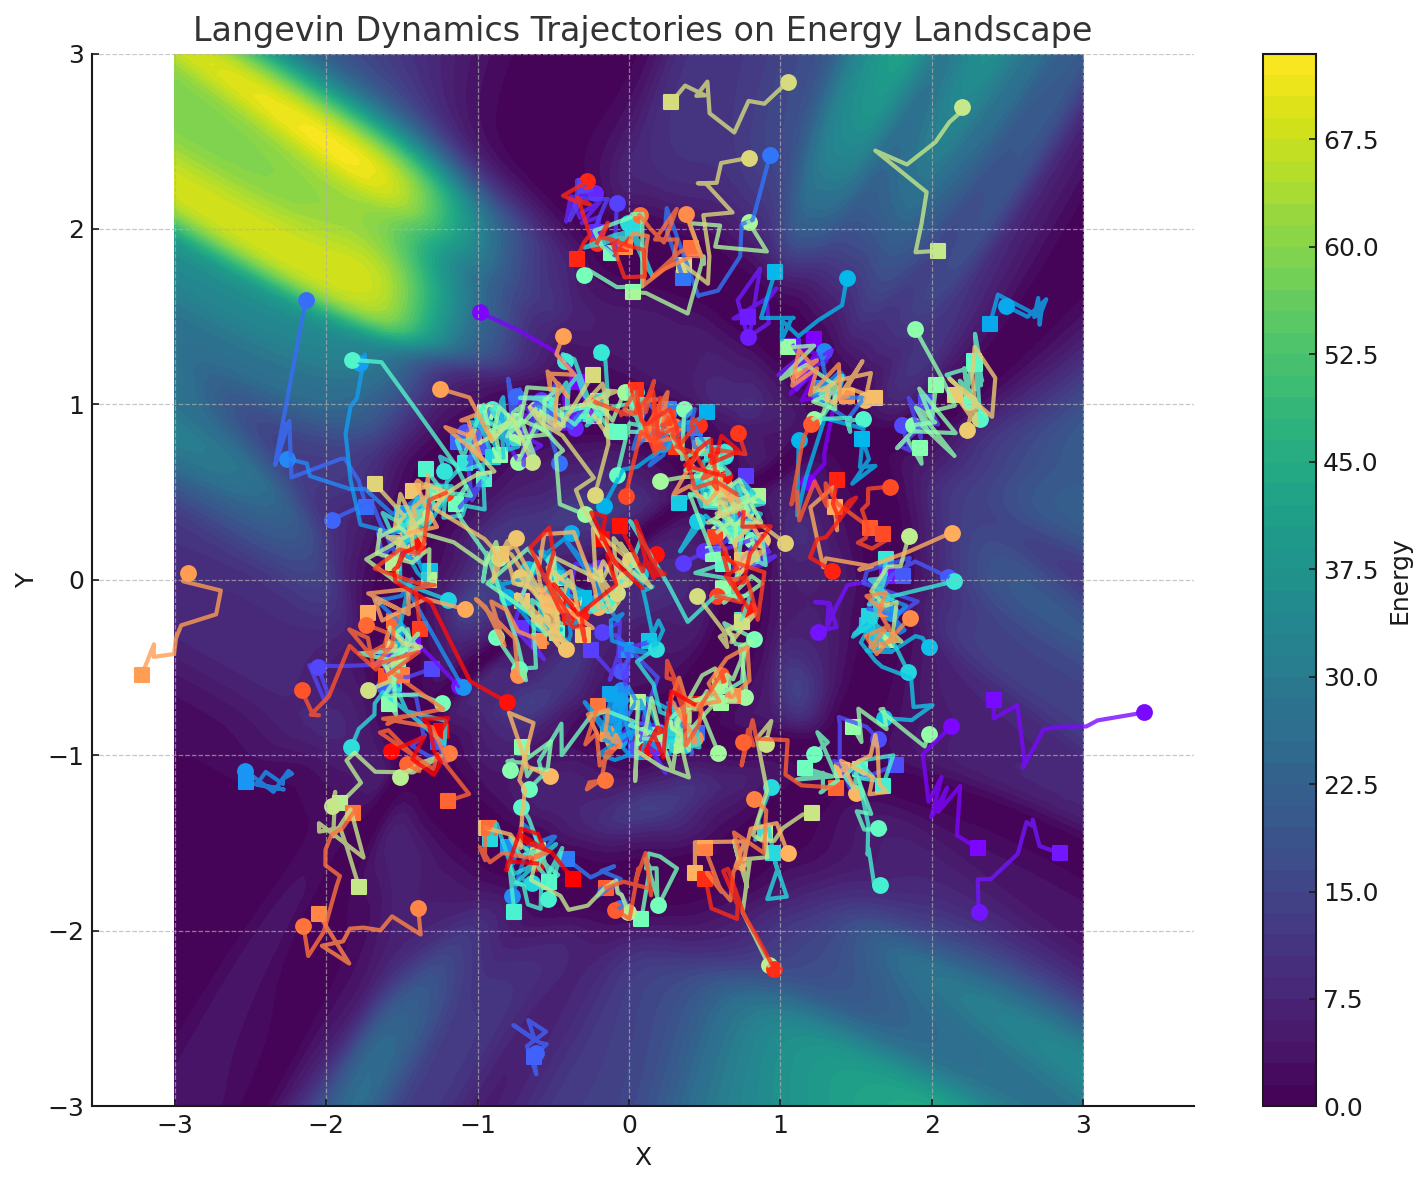

In [14]:
priors = jax.random.normal(key, (200, 2))
trajectories = sample_langevin_dynamics_with_trajectory(key, state, state.params, priors, num_steps=10, step_size=0.01)

visualize_langevin_trajectories(state, state.params, trajectories)

### Pre-conditioned Langevin Dynamics

In [15]:
@partial(jax.jit, static_argnums=(5, 6), backend='cpu')
def sample_pre_conditioned_langevin_dynamics_with_trajectory(key, state, params, x, preconditioner, num_steps, step_size):
    def step(carry, _):
        i, x, subkey = carry
        noise = jax.random.normal(subkey, shape=x.shape)
        grad = grad_energy_wrt_x(state, params, x)
        precond_sqrt = jax.scipy.linalg.sqrtm(preconditioner)
        precond_sqrt = jnp.real(precond_sqrt)
        
        x = x - (step_size / 2.) * jnp.einsum('ij,kj->ki', preconditioner, grad) + jnp.sqrt(step_size) * jnp.einsum('ij,kj->ki', precond_sqrt, noise)
        return (i + 1, x, jax.random.fold_in(subkey, i)), x
    
    _, trajectory = jax.lax.scan(step, (0, x, key), None, length=num_steps)
    return trajectory

In [16]:
num_samples = 20
num_samples_preconditioned = 500
conditioner_prior = jax.random.normal(key, (num_samples_preconditioned, 2))
random_samples = sample_langevin_dynamics(key, state, state.params, conditioner_prior, num_steps=200, step_size=0.01)
preconditioner = jnp.cov(random_samples, rowvar=False)

In [17]:
sample_prior = jax.random.normal(key, (num_samples, 2))

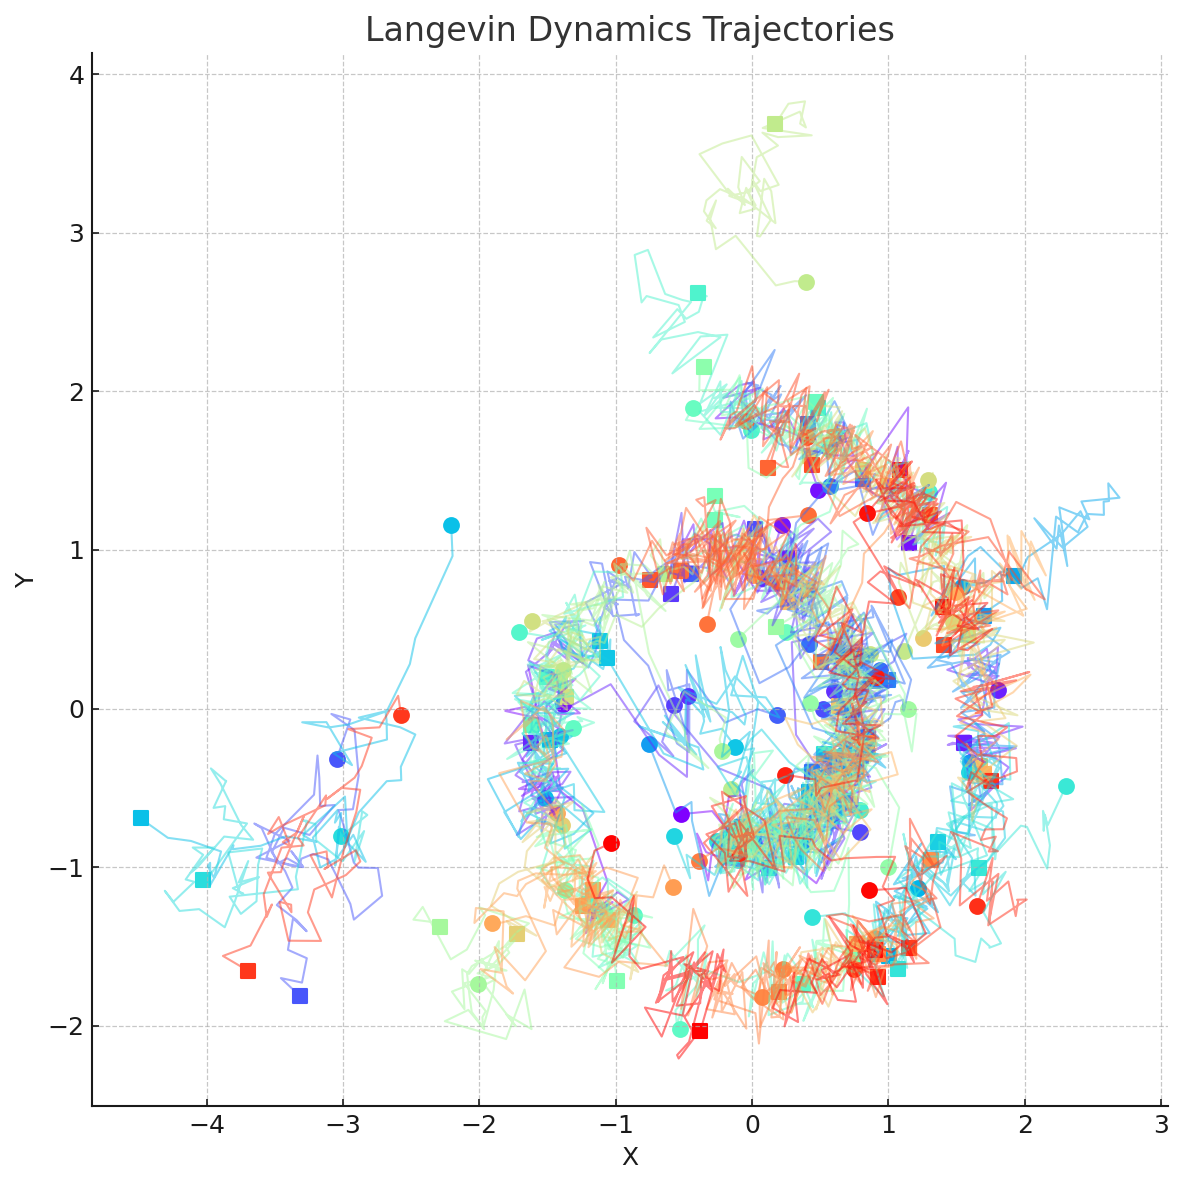

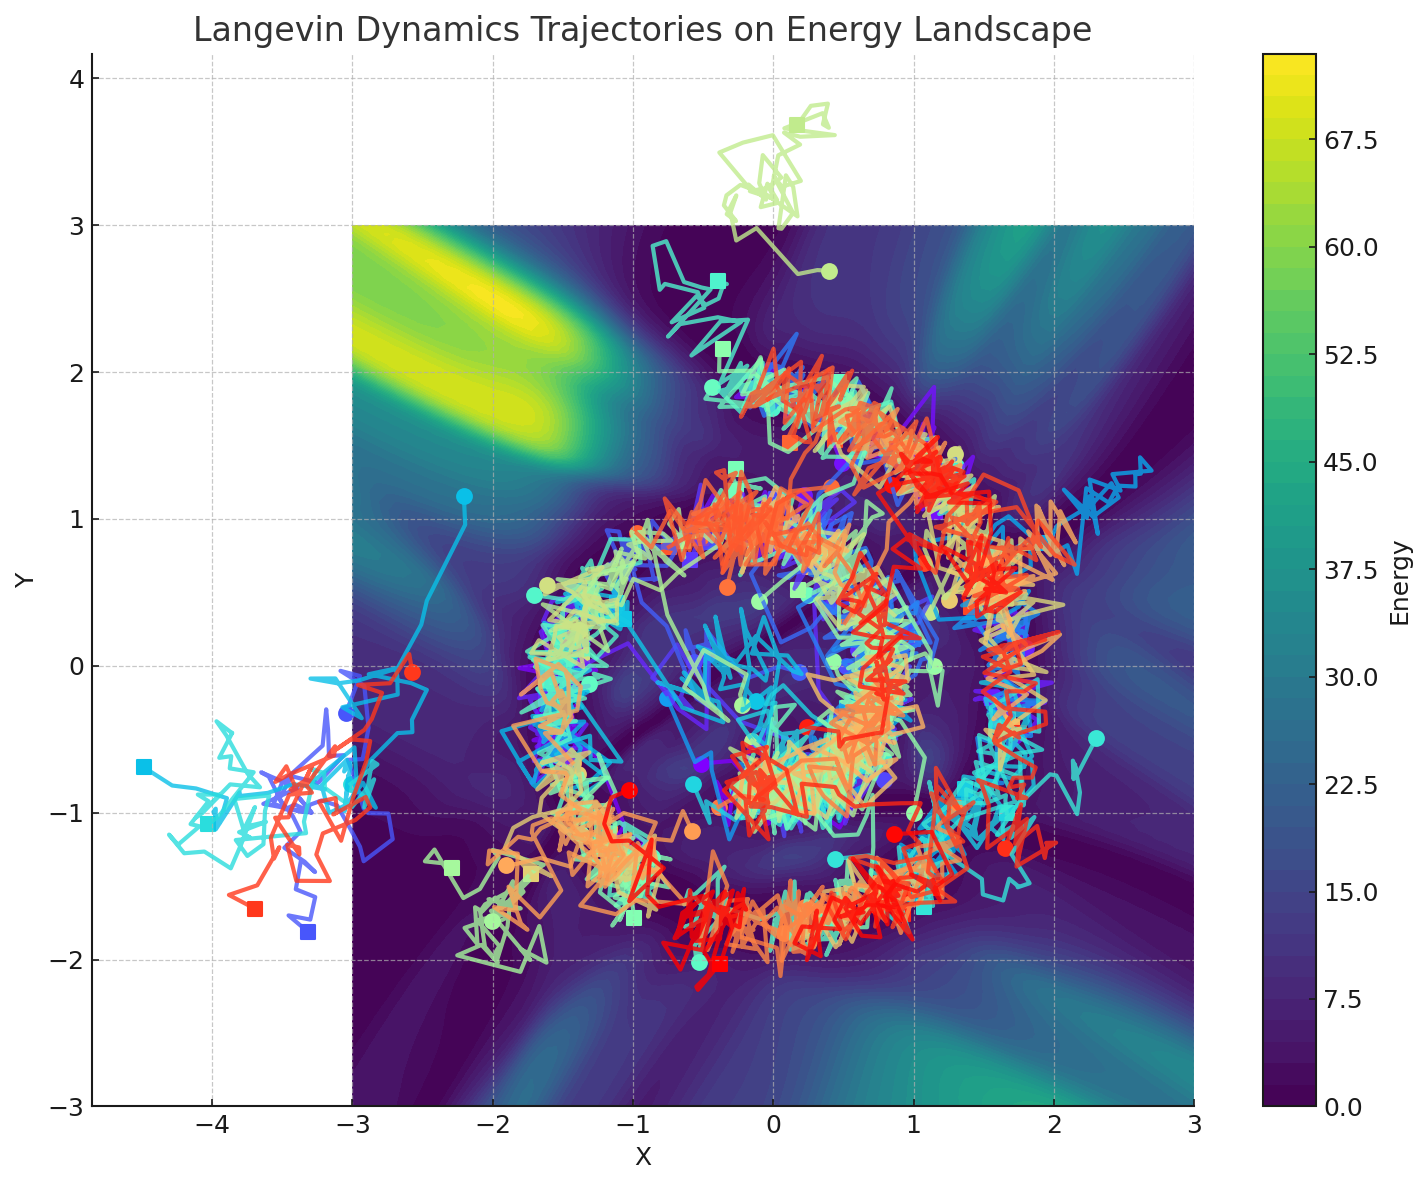

In [18]:
trajectories = sample_pre_conditioned_langevin_dynamics_with_trajectory(key, state, state.params, prior[:100], preconditioner, num_steps=50, step_size=0.01)
visualize_langevin_trajectories(state, state.params, trajectories)

### Hamiltonian Monte Carlo Sampling

#### Blackjax

In [62]:
def log_density_fn(x):
    return -energy(state, state.params, x)

In [63]:
step_size = 0.01
hmc = blackjax.hmc(
    log_density_fn,
    step_size=step_size,
    inverse_mass_matrix=preconditioner,
    num_integration_steps=10,
)

initial_position = {"loc": np.array([1., 1.]), "log_scale": np.array([1., 1.])}
sample_prior = jax.random.normal(key, (2,))
initial_state = hmc.init(sample_prior)
hmc_kernel = jax.jit(hmc.step)


In [64]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [65]:
inferred_states = inference_loop(key, hmc_kernel, initial_state, 10000)

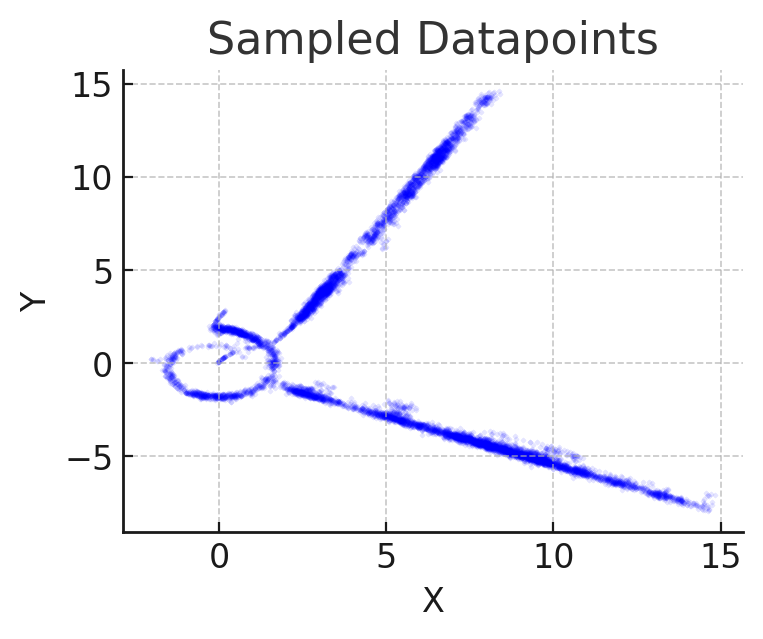

In [66]:
plt.figure(figsize=(4, 3), dpi=200)
plt.scatter(inferred_states.position[:, 0], inferred_states.position[:, 1], s=1, color='blue', alpha=0.1)
# plt.scatter(x[:10000, 0], x[:10000, 1], s=1, color='red', alpha=0.08)
plt.title('Sampled Datapoints')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#### My Implementation

In [46]:
Sigma = jnp.eye(2, 2)
Sigma_inv = jax.scipy.linalg.inv(Sigma)
eta = 0.01
L = 2

In [63]:
def sample_momentum(key, inverse_mass_matrix, num_samples):
    return jax.random.multivariate_normal(key, jnp.zeros(2), inverse_mass_matrix, shape=(num_samples,))

@jax.jit
def hamiltonian(state, params, position, momentum):
    return energy(state, params, position) + 0.5 * jnp.einsum('ki,ki->k', momentum, jnp.einsum('ij,kj->ki', Sigma_inv, momentum))

@jax.jit
def alpha(state, params, position, momentum, position_proposal, momentum_proposal):
    return jnp.minimum(1., jnp.exp(hamiltonian(state, params, position, momentum) - hamiltonian(state, params, position_proposal, momentum_proposal)))

In [64]:
position = jax.random.normal(key, (10, 2))

momentum = sample_momentum(key, Sigma, 10)

# jnp.einsum('ij,kj->ki', Sigma_inv, momentum)
hamiltonian(state, state.params, position, momentum)

alpha(state, state.params, position, momentum, position, momentum)

Array([1.       , 0.9999976, 0.9999981, 1.       , 1.       , 1.       ,
       0.9999987, 0.9999994, 1.       , 1.       ], dtype=float32)

In [65]:
position = jax.random.normal(key, (1, 2))

for _ in range(10):
    momentum = sample_momentum(key, Sigma, 1)
    prev_position = position
    prev_momentum = momentum
    
    position = position - (eta / 2.) * grad_energy_wrt_x(state, state.params, position)
    for _ in range(L):
        position = position + eta * jnp.einsum('ij,kj->ki', Sigma_inv, momentum)
        momentum = momentum - eta * grad_energy_wrt_x(state, state.params, position)

    position = position + (eta / 2.) * jnp.einsum('ij,kj->ki', Sigma_inv, momentum)
    momentum = momentum - (eta / 2.) * grad_energy_wrt_x(state, state.params, position)
    
    if jax.random.uniform(key) < alpha(state, state.params, prev_position, prev_momentum, position, momentum):
        print('Accepted')
    else:
        print('Rejected')
   

Rejected
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted


In [72]:
def batched_hmc_with_trajectory(key, state, params, batch_size, num_steps, L, eta, Sigma, Sigma_inv):
    # Initialize positions for all samples in the batch
    positions = jax.random.normal(key, (batch_size, 2))
    
    # Initialize trajectory array to store positions at each step
    trajectory = jnp.zeros((num_steps + 1, batch_size, 2))
    trajectory = trajectory.at[0].set(positions)

    def step(step_index, carry):
        key, positions, trajectory = carry
        key, subkey1, subkey2 = jax.random.split(key, 3)

        # Sample momentum for all samples in the batch
        momenta = sample_momentum(subkey1, Sigma, batch_size)
        prev_positions = positions
        prev_momenta = momenta

        # Half step for momentum
        positions = positions - (eta / 2.) * grad_energy_wrt_x(state, params, positions)

        # Full steps for position and momentum
        def leapfrog_step(_, step_state):
            pos, mom = step_state
            pos = pos + eta * jnp.einsum('ij,bj->bi', Sigma_inv, mom)
            mom = mom - eta * grad_energy_wrt_x(state, params, pos)
            return (pos, mom)

        positions, momenta = jax.lax.fori_loop(0, L, leapfrog_step, (positions, momenta))

        # Half step for momentum
        positions = positions + (eta / 2.) * jnp.einsum('ij,bj->bi', Sigma_inv, momenta)
        momenta = momenta - (eta / 2.) * grad_energy_wrt_x(state, params, positions)

        # Compute acceptance probabilities
        accept_probs = alpha(state, params, prev_positions, prev_momenta, positions, momenta)
        
        # Generate random numbers for acceptance
        u = jax.random.uniform(subkey2, (batch_size,))
        
        # Create a boolean mask for accepted samples
        accepted = u < accept_probs

        # Update positions based on acceptance
        positions = jnp.where(accepted[:, None], positions, prev_positions)

        # Store the updated positions in the trajectory
        trajectory = trajectory.at[step_index + 1].set(positions)

        return (key, positions, trajectory)
    
    _, final_positions, trajectory = jax.lax.fori_loop(0, num_steps, step, (key, positions, trajectory))

    return final_positions, trajectory

In [93]:
samples, trajectories = batched_hmc_with_trajectory(key, state, state.params, 5, 5000, 2, 0.01, Sigma, Sigma_inv)
    

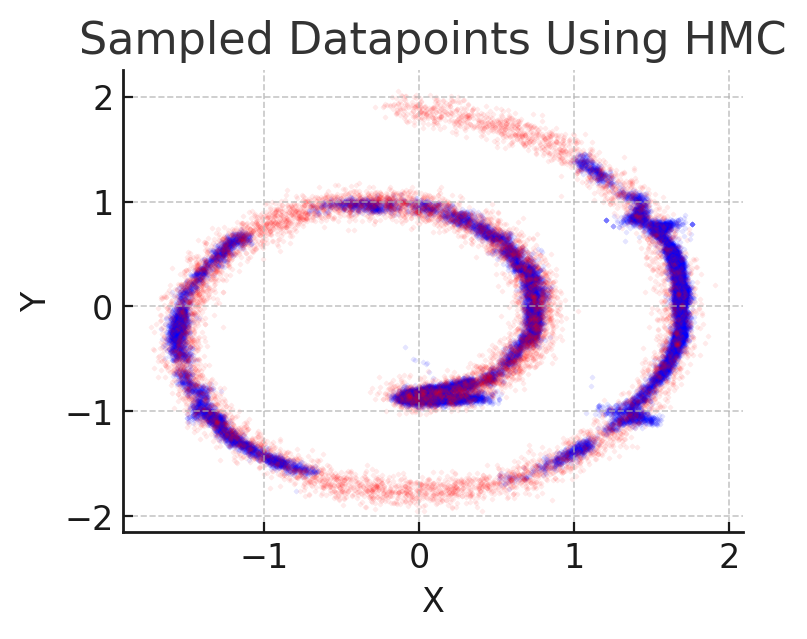

In [94]:
samples = trajectories.reshape(-1, 2)
plt.figure(figsize=(4, 3), dpi=200)
plt.scatter(samples[:, 0], samples[:, 1], s=1, color='blue', alpha=0.1)
plt.scatter(x[:10000, 0], x[:10000, 1], s=1, color='red', alpha=0.08)
plt.title('Sampled Datapoints Using HMC')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

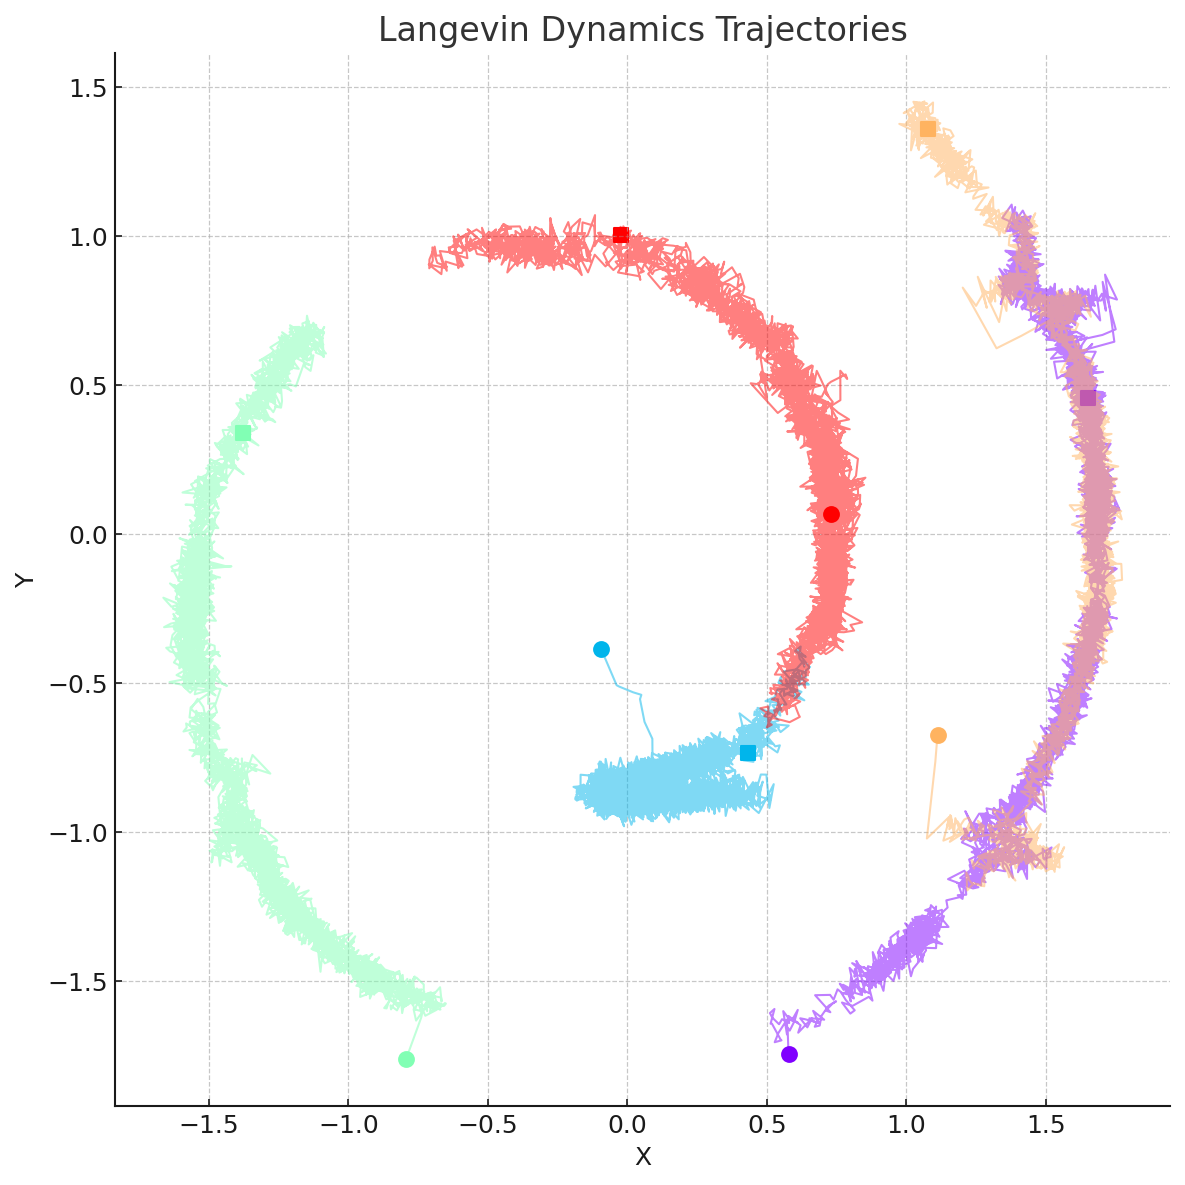

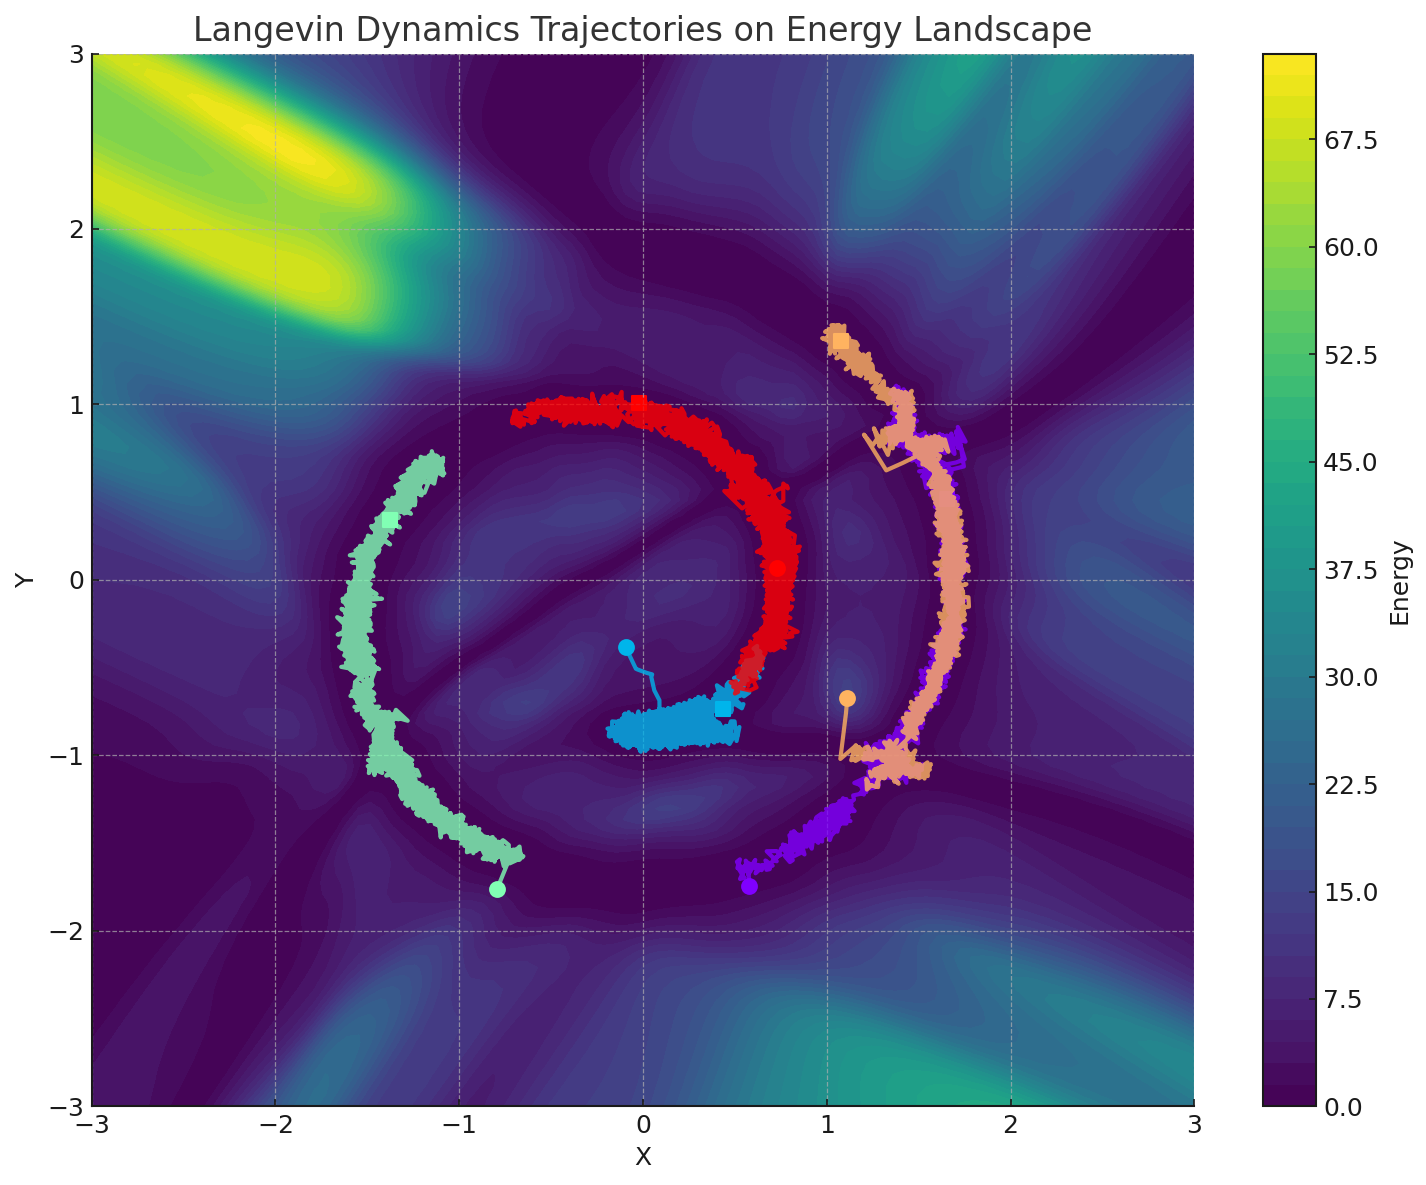

In [95]:
visualize_langevin_trajectories(state, state.params, trajectories)